# Implement certainty estimation on CNN predictions
In this notebook, I implement methods to estimate the certainty of CNN model predictions. Specifically, I train logistic regression models on the CNN's output, evaluate their performance, and discuss the advantages, applications, and limitations of these approaches.

In [ ]:
# Install required packages
!pip install h5py
!pip install imblearn

In [1]:
work_path = "/dss/dsshome1/lxc0B/di29let/ondemand/Projects/Repositories/certainty-estimator"
import torch
import os
import sys
import h5py as h5
import numpy as np
sys.path.append(work_path)
from utils import test
from utils.datasets import MRI_dataset, make_masked_testset, make_noise_testset
from torch.utils.data import random_split
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [2]:
dev = torch.device('cuda:0')

## Generate corrupted predictions

First we need to generate corrupted data by masking parts of the image, as during training. But now using a more convenient function, which allows the generation of specified levels of corruption in images from one of three datasets, now defined as follows:
- Dataset 0: Used for training of the CNN (66% of total data)
- Dataset 1: Used for validation of the CNN or training of the certainty estimators (22% of total data)
- Dataset 2: Used for validation of certainty estimators (18% of total data)

## Generate CNN outputs to train certainty estimators
Next we need to gather the CNN output to train certainty estimators. I tested 2 approaches:
- Get a Monte Carlo dropout sample of the logits for each class upon running 50 forward passes on the neural network. In order to provide meaningfull information for the certainty estimation, the samples have to be ordered. For each class I compute the percentiles from 2 to 98 (to exclude potential outliers), resulting in 49 values per class. These values are further stacked along one dimension, ordered by the class mean output, as illustrated below.
  
<img src="../Dropout_estimator.png" alt="Dropout estimator" width='1080'/>

- Get the high level features from the CNN by extracting the output of the last fully connected layers, consisting in a array of 512 elements.

<img src="../Hfeatures_estimator.png" alt="Dropout estimator" width='1080'/>

In [6]:
import time

def generate_corrupt_data(corruption_range,dataset_generator, dataset_nr, dropout_p, mode=['hfeatures'],iterations=60,bsize=16, replicas=5):
    """
        Generate corrupted data and evaluate the model's predictions based on corruption levels.
    
        Args:
            corruption_range (list): A list defining different levels of corruption to apply to the dataset.
            dataset_generator (function): A function that generates the dataset given a corruption level and dataset number.
            dataset_nr (int): The dataset number used to generate the dataset.
            dropout_p (float): Dropout probability for the model.
            mode (list, optional): List of prediction modes. Default is ['hfeatures'].
            iterations (int, optional): Number of iterations for batch retrieval. Default is 60.
            bsize (int, optional): Batch size. Default is 16.
            replicas (int, optional): Number of replicas for each corruption level. Default is 5.
    
        Returns:
            tuple: Tuple containing:
                - fts (dict): Extracted features for each mode across corruption levels.
                - wrong (dict): Incorrect predictions for each mode across corruption levels.
        """
    
    #function to generate dropout distributions
    def prediction_features(sample):
        """
        Generate ordered dropout distributions of predictions for a given input image.

        Args:
            sample (torch.Tensor): Input image.

        Returns:
            tuple: Tuple containing:
                - dist_qs (torch.Tensor): Predictions ordered by percentile and class mean.
                - predict (torch.Tensor): Predicted class labels.
        """
        with torch.no_grad():
            if dropout_p == 0:
                # Get deterministic predictions without dropout
                mean_pred = net(sample)
                # Tile to match the output size of dropout
                preds = torch.tile(mean_pred.unsqueeze(2),(50,))
            else:
                # If dropout is enabled, get multiple forward passes for certainty estimation
                mean_pred, std_pred, preds = net.get_prediction_stats(sample,n_samples=50, batch_size=bsize)
        
        # Get predicted classes and sort predictions
        predict = torch.argmax(mean_pred,dim=1).to(dev)
        sort_pred = torch.sort(mean_pred,descending=True)

        # Calculate distribution quantiles for each class
        dist_qs = []
        for q in np.arange(0.02,1,0.02):
            for cl in range(3):
                dist_qs.append(torch.quantile(preds,q,dim=2)[np.arange(bsize),sort_pred[1][:,cl]])

        return torch.stack(dist_qs,dim=1), predict
    
    wrong = {}
    fts = {}
    for key in mode:
        wrong[key] = []
        fts[key] = []

    features = {}
    predict = {}
    
    start = time.time()

    for nl,corrup in enumerate(corruption_range):
        print(corrup)

        for k in range(replicas):
            test_set = dataset_generator(corrup, dataset_nr)
            imageloader = iter(DataLoader(test_set,batch_size=bsize,drop_last=True))

            for i in range(iterations):
                try:
                    sample = next(imageloader)
                    
                    with torch.no_grad():
                        if 'hfeatures' in mode:
                            # Extract high-level features from CNN
                            features['hfeatures'], prediction = net.get_features(sample[0])
                            predict['hfeatures'] = torch.argmax(prediction,dim=1)
                        if 'dropout' in mode:
                            # Compute dropout features
                            features['dropout'], predict['dropout'] = prediction_features(sample[0])
                    
                    # Store results for each mode
                    for mode_name in mode:
                        if i==0 and k==0: 
                            wrong[mode_name].append(torch.where(predict[mode_name]!=sample[1].squeeze(),1,0))
                            fts[mode_name].append(features[mode_name])
                        else:
                            wrong[mode_name][nl] = torch.concatenate((wrong[mode_name][nl],torch.where(predict[mode_name]!=sample[1].squeeze(),1,0)))
                            fts[mode_name][nl] = torch.concatenate((fts[mode_name][nl],features[mode_name]))
                except StopIteration:
                    # Break out of loop when there are no more samples in the dataloader
                    break
                    #pass
    
    # Convert lists of incorrect predictions and features into stacked tensors and move to the CPU
    for mode_name in mode:
        wrong[mode_name] = torch.stack(wrong[mode_name]).cpu()
        fts[mode_name] = torch.stack(fts[mode_name]).cpu()
    
    end = time.time()
    print(end-start)
    
    return fts, wrong

## Test masking with trained models
We are going to test the models trained with different dropout extent on masked validation and test datasets. Two different outputs will be gathered here: the first is the Monte-Carlo dropout output (50 forward passes in the CNN) and the second are the high-level features of the CNN (single forward pass).

In [ ]:
# Dropouts to test
dropouts = [0,0.005,0.01,0.02,0.05,0.1,0.15,0.2]
drop_names = ['0','0005','001','002','005','01','015','02']

# Masking fractions to test
fraction_levels = np.arange(0,0.97,0.05)

for drop in dropouts:
    print(drop)
    # Load model
    model_path = f"/dss/dssfs02/lwp-dss-0001/pr84qa/pr84qa-dss-0000/ricardo/data/Projects/MRI_classification/models/resnet18/pretrained/dropout_allconvs/dp_rate_{drop}_nonorm_masked_extendedtrain06/22_10_2024"
    check_path = os.path.join(model_path,f"resnet18_epoc_20")
    net, _ = test.load_model(check_path,dev,drop)
    
    # Make sure dropout is the desired one
    net.dropout.p = drop
    
    uncertainty_features = {key: {} for key in ['train','validation']}

    for i, key in enumerate(uncertainty_features):
        # Dataset generator function
        def data_gen(fraction, dataset_nr):
            test_set = make_masked_testset(fraction,32, dataset_nr,dev=dev)
            return test_set
        
        # Get features and classification correctness from corrupted images
        fts, wrong = generate_corrupt_data(fraction_levels,data_gen, i+1, drop, mode=['hfeatures'],replicas=2)
        
        uncertainty_features[key]['features'] = fts
        uncertainty_features[key]['wrong'] = wrong
    
    torch.save(uncertainty_features,os.path.join(model_path,'uncertainty_all.pth'))

## Train certainty estimators on the CNN outputs
The next step is to train the certainty estimators, based on logistic regression classifiers, on the two types of generated CNN outputs. The CNN validation and test datasets will be used as the training and validation datasets of the uncertainty estimators, respectively.

First, we define a function to get the training data into a dictionary and train the estimator models.

In [13]:
from sklearn.linear_model import LogisticRegression

In [14]:
fraction_levels = np.arange(0,0.97,0.05)

In [15]:
# load train data to a dictionary and train uncertainty estimators
dropouts = [0,0.005,0.01,0.02,0.05,0.1,0.15,0.2]
drop_names = ['0','0005','001','002','005','01','015','02']
estimator_type = ['dropout','hfeatures']

def train_estimators(C=[1,1],dropout_predictions=False,features_file = 'uncertainty_all.pth',clf=None):
    """
    Train uncertainty estimators (logistic classifiers) on extracted features for different dropout rates.

    This function loads the feature representations from previously saved models, and uses them to 
    train logistic regression models to predict whether the model's classification is correct or not 
    (based on 'wrong' labels). The trained classifiers are stored in a dictionary for later use.

    Args:
        C (list of float, optional): Regularization strengths for the logistic regression classifiers 
                                     for each estimator type. Default is [1, 1].
        dropout_predictions (bool, optional): If True, train using dropout-based predictions. 
                                              If False, train on hidden features ('hfeatures'). Default is False.
        features_file (str, optional): Filename of the .pth file containing features and wrong labels. 
                                       Default is 'uncertainty_all.pth'.
        clf (dict, optional): Pre-trained classifiers for each dropout rate and estimator type. 
                              If None, new classifiers will be trained. Default is None.

    Returns:
        dict: A dictionary containing trained classifiers for each dropout rate and estimator type.
    """

    # Initialize dictionary to store uncertainty estimators
    uncertainty_drops = {}
    for type in estimator_type:
        uncertainty_drops[type] = {key: {} for key in drop_names}
    
    for drop_name in drop_names:
        # Load the features and wrong labels from the saved file
        model_path = f"/dss/dssfs02/lwp-dss-0001/pr84qa/pr84qa-dss-0000/ricardo/data/Projects/MRI_classification/models/resnet18/pretrained/dropout_allconvs/dp_rate_{drop_name}_nonorm_masked_extendedtrain06/29_05_2024"     
        uncertainty_tm = torch.load(os.path.join(model_path,features_file))
        
        for i, type in enumerate(estimator_type):
        
            print(drop_name)
            
            for key in ['train','validation']:
                uncertainty_drops[type][drop_name][key] = {}
                for data_name in ['features','wrong']:
                    uncertainty_drops[type][drop_name][key][data_name] = uncertainty_tm[key][data_name][type]
            
            if dropout_predictions:
                pred_type = 'dropout'
            else:
                pred_type = type

            # Prepare the training features and labels for the logistic regression model
            fts = uncertainty_drops[type][drop_name]['train']['features']        
            wrong = uncertainty_drops[pred_type][drop_name]['train']['wrong']
            
            # Reshape the features and remove any NaN values
            Xtrain = fts.view(-1,fts.size(2))
            gind = torch.where(torch.isnan(Xtrain[:,1])==0)[0]
            Xtrain = Xtrain[gind,:]
            wrong_train = wrong.view(-1,1)[gind,:]

            # Create binary labels
            y = torch.where(wrong_train==0,1,0).squeeze()

            # Train the logistic regression classifier
            if not clf:
                # Train a new logistic regression model
                uncertainty_drops[type][drop_name]['clf'] = LogisticRegression(C=C[i],random_state=0,max_iter=3000).fit(Xtrain, y)
            else:
                # Use the provided pre-trained classifier
                uncertainty_drops[type][drop_name]['clf'] = clf[type][drop_name]['clf']
    
    return uncertainty_drops

Then we define a function to check how the uncertainty estimators perform by comparing their probability output with actuall accuracies.

In [10]:
from sklearn.linear_model import LinearRegression

hbins = np.arange(0.3,1.02,0.02)

def get_estimator_accuracy(uncertainty_drops,dataset='validation',estimator_mix=False,masking_levels=None):
    """
    Computes and updates the accuracy and confidence statistics for different uncertainty estimators.

    This function calculates accuracy, confidence (certainty), and various metrics across a range of certainty 
    estimators (dropout or hfeatures). It computes accuracy metrics for the entire dataset as well as for different 
    masking levels.

    Args:
        uncertainty_drops (dict): A dictionary containing trained certainty estimators, their predictions,
                                  and 'wrong' labels (whether the prediction was wrong).
        dataset (str, optional): The dataset to compute accuracy for, either 'train' or 'validation'. 
                                 Default is 'validation'.
        estimator_mix (bool, optional): If True, combines different estimators; if False, uses individual estimators.
                                        Default is False.
        masking_levels (list, optional): List of masking levels, used if estimator_mix is True. Default is None.

    Returns:
        dict: Updated `uncertainty_drops` dictionary with computed accuracy and confidence statistics.
    """
    
    # Define histogram bins for confidence (certainty) values
    hbins = np.arange(0.3,1.02,0.02)
    uncertainty_drops['model confidence'] = hbins[:-1]+0.01
    
    
    for type in estimator_type:
        for drop_name in drop_names:
            # Extract validation features and wrong predictions
            fts_val = uncertainty_drops[type][drop_name][dataset]['features']
            wrong_val = uncertainty_drops[type][drop_name][dataset]['wrong']
            X = fts_val.view(-1,fts_val.size(2))

            # Compute the predicted probabilities of correct classifications (certainty)
            if estimator_mix:
                pred_proba = uncertainty_drops[type][drop_name]['clf'].predict_proba(fts_val).reshape(-1,1)
            else:
                pred_proba = uncertainty_drops[type][drop_name]['clf'].predict_proba(X)[:,1]
                
            # Create histograms for all predictions
            b = np.histogram(pred_proba,bins=hbins)
            
            # Create histograms for wrong predictions
            c = np.histogram(pred_proba[wrong_val.view(-1,1).squeeze()==1],bins=hbins)
            
            # Identify bins where we don't have NaN values (to avoid dividing by zero)
            with np.errstate(divide='ignore', invalid='ignore'):
                ind_nan = ~np.isnan(1-c[0]/b[0])
                uncertainty_drops[type][drop_name]['global_nan_bin'] = ind_nan
               
            # Store overall accuracy and confidence
            uncertainty_drops[type][drop_name]['acc_total'] = 1-c[0]/b[0]
            uncertainty_drops[type][drop_name]['conf_total'] = b[0]
            uncertainty_drops[type][drop_name]['accuracy'] = 1 - torch.sum(wrong_val.view(-1,1))/wrong_val.view(-1,1).size(0)

            # Initialize lists to store per-mask accuracy and confidence
            predm = []
            pred_acc = []
            uncertainty_drops[type][drop_name]['nan_bin'] = []
            
            # Compute accuracy and certainty for each masking level
            for ind in range(fts_val.size(0)):
                if estimator_mix:
                    pred_proba = uncertainty_drops[type][drop_name]['clf'].predict_proba(fts_val[ind,:,:].squeeze(),
                                                                                         mask_levels=masking_levels[ind]).reshape(-1,1)
                else:
                    pred_proba = uncertainty_drops[type][drop_name]['clf'].predict_proba(fts_val[ind,:,:].squeeze())[:,1]
                
                # Compute per-mask histograms
                bm,_ = np.histogram(pred_proba,bins=hbins)
                cm,_ = np.histogram(pred_proba[wrong_val[ind,:]==1],bins=hbins)
                
                # Calculate per-mask accuracy and certainty
                with np.errstate(divide='ignore', invalid='ignore'):
                    pred_acc.append(1-cm/bm)
                    predm.append(bm/np.max(bm))
                    ind_nan = ~np.isnan(1-cm/bm)
                    uncertainty_drops[type][drop_name]['nan_bin'].append(ind_nan)
            
            # Store per-mask accuracy and confidence
            uncertainty_drops[type][drop_name]['acc_bin'] = np.array(pred_acc)
            uncertainty_drops[type][drop_name]['conf_bin'] = np.array(predm)
            uncertainty_drops[type][drop_name]['nan_bin'] = np.array(uncertainty_drops[type][drop_name]['nan_bin'])
    
    return uncertainty_drops

### Certainty estimation: first glance
First we check the accuracy of the CNN model outputs, used to train the uncertainty estimators, on the masked images (validation set).

### Training certainty estimators and checking their performance
We train the logistic regression estimators for the range of dropouts tested and get the statistics on their performance.

In [ ]:
# get statistics using either hfeatures or dropout prediction outputs to train the estimators
uncertainty_drops = get_estimator_accuracy(train_estimators(dropout_predictions=False))

Before moving on, we just check the overall accuracy of the CNN models on the masked images (validation set) to make sure there are no big variations accross conditions.

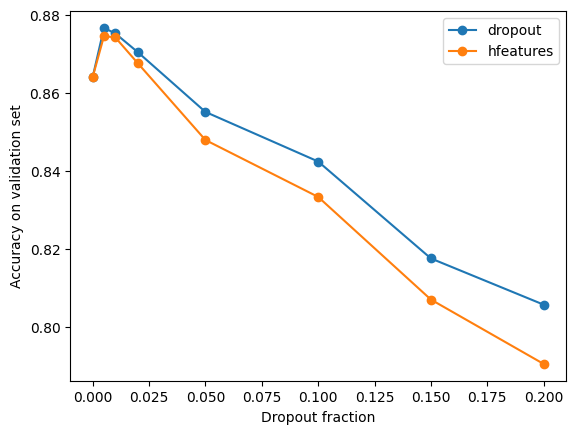

In [17]:
accuracy = []
for drop_name in drop_names:
    accuracy.append([uncertainty_drops['dropout'][drop_name]['accuracy'],uncertainty_drops['hfeatures'][drop_name]['accuracy']])

plt.plot(dropouts,np.array(accuracy),'o-')
plt.ylabel('Accuracy on validation set')
plt.xlabel('Dropout fraction')
plt.legend(estimator_type)
plt.show()

Then we check how well the certainty estimators can predict actual accuracy in the global data, by lamping together all masking levels. Let's have a look at models based on an intermediate dropout level.

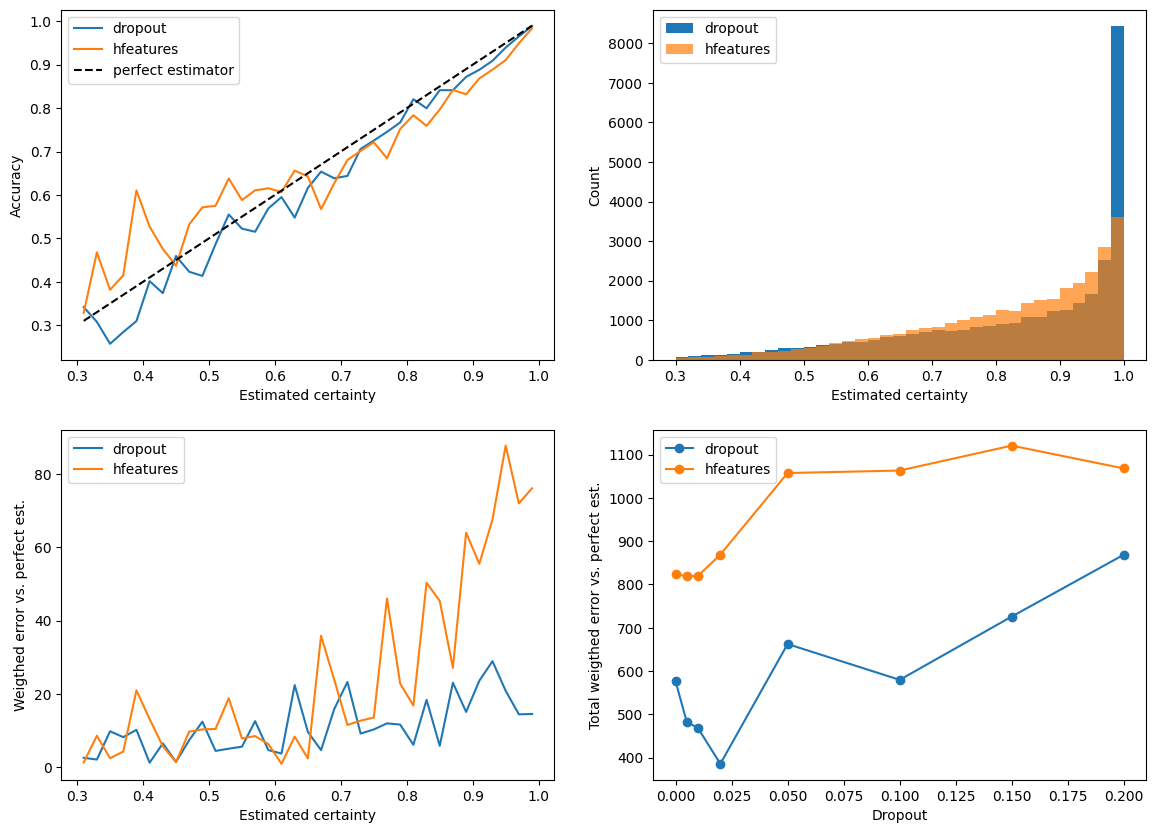

In [18]:
fig, axs = plt.subplots(2,2,figsize=(14,10))
ex_drop = '002'
xp = uncertainty_drops['model confidence']
yp = np.array([uncertainty_drops['dropout'][ex_drop]['acc_total'],
               uncertainty_drops['hfeatures'][ex_drop]['acc_total']]).T

axs[0,0].plot(xp,yp)
axs[0,0].plot(xp,xp,color='black',linestyle='dashed')
axs[0,0].set(xlabel='Estimated certainty',ylabel='Accuracy')
axs[0,0].legend([estimator_type[0],estimator_type[1],'perfect estimator'])

yc = np.array([uncertainty_drops['dropout'][ex_drop]['conf_total'],
                uncertainty_drops['hfeatures'][ex_drop]['conf_total']]).T
    
ye = np.abs(yp-np.tile(xp.reshape(-1,1),(1,2)))*yc

#compute deviation from perfect estimator for all dropouts
y_err = np.zeros((len(dropouts),2))
for i, drop_name in enumerate(drop_names):
    yp = np.array([uncertainty_drops['dropout'][drop_name]['acc_total'],
               uncertainty_drops['hfeatures'][drop_name]['acc_total']]).T
    
    yc = np.array([uncertainty_drops['dropout'][drop_name]['conf_total'],
                uncertainty_drops['hfeatures'][drop_name]['conf_total']]).T
    
    y_err[i,:] = np.sum(np.abs(yp-np.tile(xp.reshape(-1,1),(1,2)))*yc,axis=0)
    
alphas = [1,0.7]
for i in range(2):
    axs[0,1].bar(xp,yc[:,i],width=0.02,alpha=alphas[i])
axs[0,1].set(xlabel='Estimated certainty',ylabel='Count')
axs[0,1].legend(estimator_type)

axs[1,0].plot(xp,ye)
axs[1,0].set(xlabel='Estimated certainty',ylabel='Weigthed error vs. perfect est.')
axs[1,0].legend(estimator_type)

axs[1,1].plot(dropouts,y_err,'o-')
axs[1,1].set(xlabel='Dropout',ylabel='Total weigthed error vs. perfect est.')
axs[1,1].legend(estimator_type)

plt.show()

In this particular example, both estimators perform decently. However, the dropout-based estimator is overall closer to a perfect estimator. The high-level features-based estimator seems to output an excess of under-estimated certainties in the range of 0.7-0.95, resulting in a higher weighted error (defined as deviation from perfect estimator multiplied by number of observations at each bin) particularly in that region. Accross all CNN training dropout extents, the total weighted error is consistently higher for the hfeatures-based estimator vs. its dropout-based counterpart.

### Checking overfitting
These results above suggest that the hfeatures-based estimators might be overfitting on the training data. So, we repeat the analysis for the training set and compare it with the results show above for the validation set.

In [ ]:
uncertainty_drops_train = get_estimator_accuracy(train_estimators(),dataset='train')

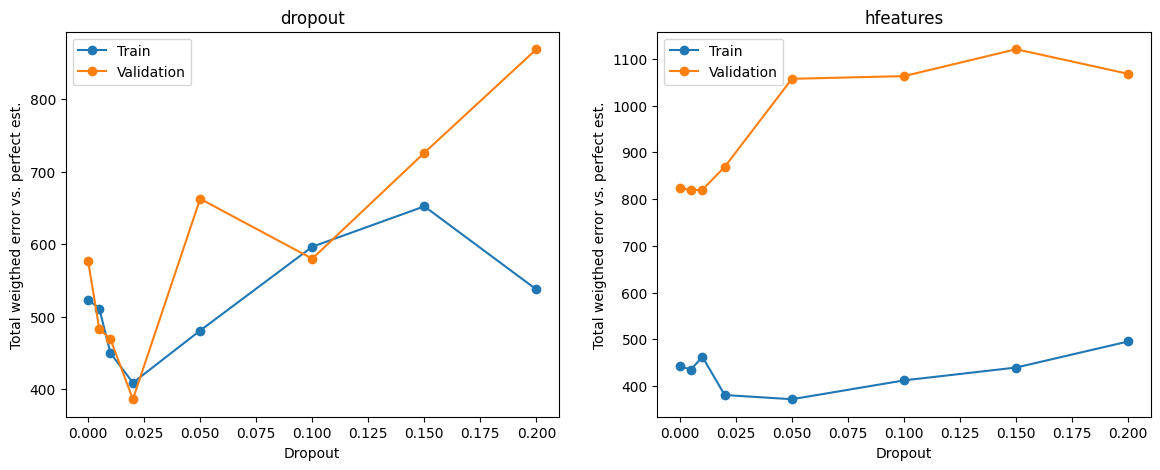

In [21]:
fig, axs = plt.subplots(1,2,figsize=(14,5))

#compute deviation from perfect estimator for all dropouts
y_err_train = np.zeros((len(dropouts),2))
for i, drop_name in enumerate(drop_names):
    yp = np.array([uncertainty_drops_train['dropout'][drop_name]['acc_total'],
               uncertainty_drops_train['hfeatures'][drop_name]['acc_total']]).T

    yc = np.array([uncertainty_drops_train['dropout'][drop_name]['conf_total'],
                uncertainty_drops_train['hfeatures'][drop_name]['conf_total']]).T
    
    y_err_train[i,:] = np.sum(np.abs(yp-np.tile(xp.reshape(-1,1),(1,2)))*yc,axis=0)
    

for i in range(2):
    axs[i].plot(dropouts,np.concatenate((y_err,y_err_train),axis=1)[:,[i+2,i]],'o-')
    axs[i].set(xlabel='Dropout',ylabel='Total weigthed error vs. perfect est.',title=estimator_type[i])
    axs[i].legend(['Train','Validation'])

plt.show()

## Hyperparameter tunning
In the training set, the difference between the two types of estimator is less remarkable. The features-based estimators are even the closest to the perfect estimator in this case. This observations point towards overfitting in the training data when using high-level features, so I tested the effect of the regularization parameter C in the loggistic regression fitting.

In [ ]:
C_values = np.arange(0.02,1.01,0.02)
hbins = np.arange(0.3,1.02,0.02)
xp = hbins[:-1]+0.01

weighted_err = []

for C in C_values:
    print(f"C={C}")
    uncertainty_drops = get_estimator_accuracy(train_estimators(C=[C,C]))
    
    w_err = np.zeros((len(dropouts),2))
    for i, drop_name in enumerate(drop_names):
        yp = np.array([uncertainty_drops['dropout'][drop_name]['acc_total'],
                   uncertainty_drops['hfeatures'][drop_name]['acc_total']]).T

        yc = np.array([uncertainty_drops['dropout'][drop_name]['conf_total'],
                uncertainty_drops['hfeatures'][drop_name]['conf_total']]).T
    
        w_err[i,:] = np.abs(yp-np.tile(xp.reshape(-1,1),(1,2)))*yc
       
    weighted_err.append(w_err)

In [24]:
stats_path = '/dss/dssfs02/lwp-dss-0001/pr84qa/pr84qa-dss-0000/ricardo/data/Projects/MRI_classification/models/resnet18/pretrained/dropout_allconvs/tests/22_10_24'
if not os.path.isdir(stats_path):
    os.makedirs(stats_path)
np.save(os.path.join(stats_path,'W_err.npy'),weighted_err)

In [23]:
#load data
C_values = np.arange(0.02,1.01,0.02)
stats_path = '/dss/dssfs02/lwp-dss-0001/pr84qa/pr84qa-dss-0000/ricardo/data/Projects/MRI_classification/models/resnet18/pretrained/dropout_allconvs/tests'
weighted_err = np.load(os.path.join(stats_path,'W_err.npy'))

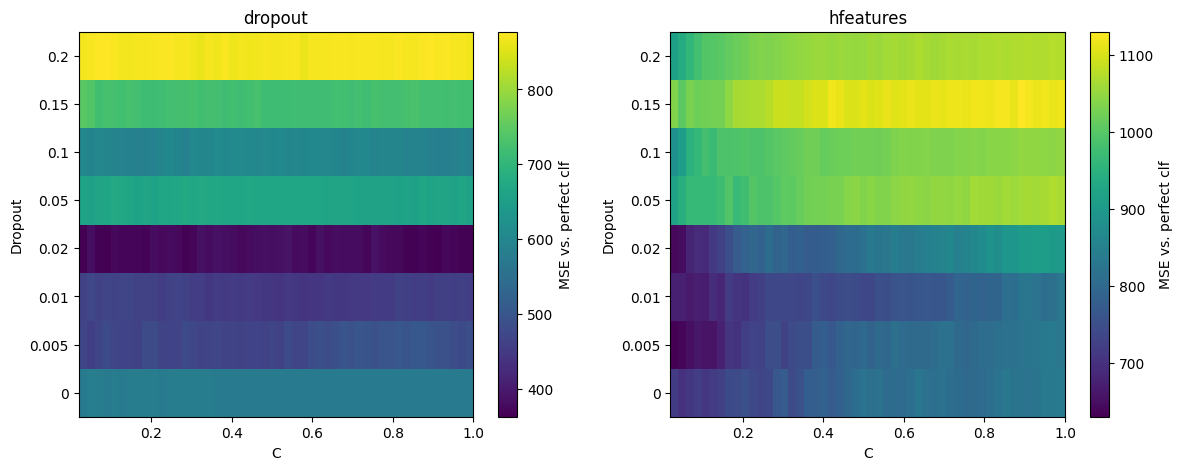

In [25]:
fig, axs = plt.subplots(1,2,figsize=(14,5))
pcm = [1,1]
cbar = [1,1]

sum_err = np.sum(np.array(weighted_err),axis=1)

for i,type in enumerate(estimator_type):
    pcm[i] = axs[i].imshow(np.array(sum_err)[:,:,i].T, aspect='auto',origin='lower',extent=[C_values[0],C_values[-1],0,len(dropouts)])
    axs[i].set(xlabel='C',ylabel='Dropout',title=f"{type}",yticks=np.arange(0.5,len(dropouts)), yticklabels=dropouts)

    cbar[i] = fig.colorbar(pcm[i],ax=axs[i])
    cbar[i].set_label('MSE vs. perfect clf')

plt.show()

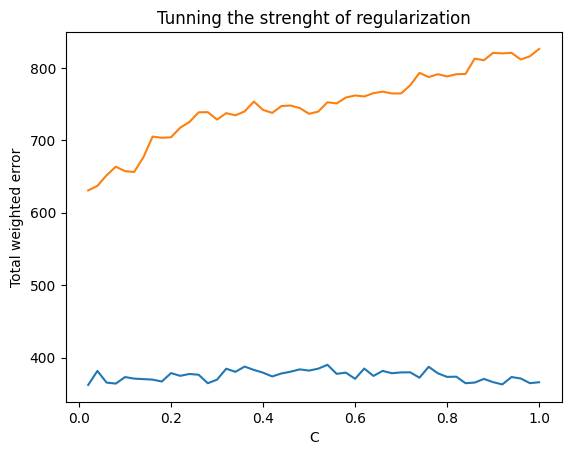

In [34]:
# Plot the minimum total error accross dropouts
plt.plot(C_values,np.min(sum_err,axis=1))
plt.title('Tunning the strenght of regularization')
plt.ylabel('Total weighted error')
plt.xlabel('C')
plt.show()

The results of the grid search above show that the defalut values of C=1 is already the best in the case of the dropout-based estimator. However, for the hfeaures-based estimator, a low C=0.02 provides optimal performance, tough still poorer than the dropout-based model. Let's now check the estimators' performance using the tunned value of C for each hfeatures-based estimator.

In [ ]:
uncertainty_drops_tunned = get_estimator_accuracy(train_estimators(C=[1,0.02]))

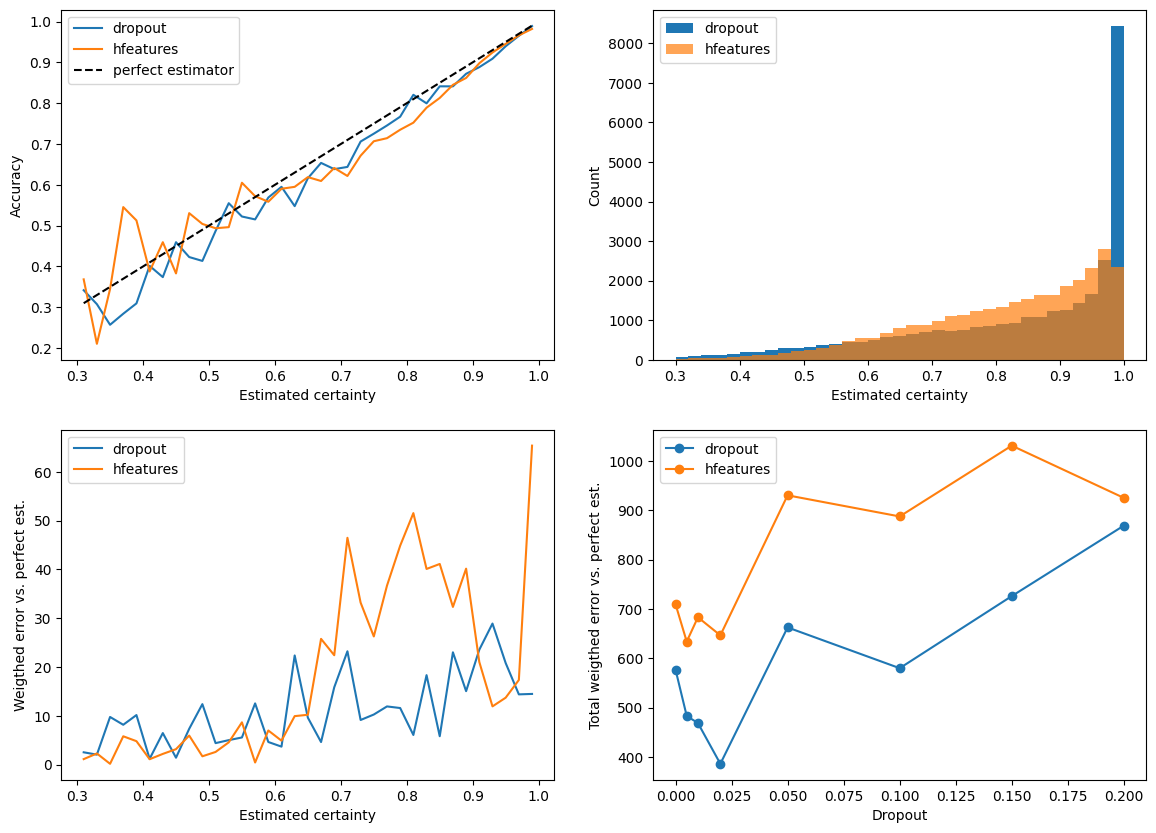

In [28]:
fig, axs = plt.subplots(2,2,figsize=(14,10))
ex_drop = '002'
xp = uncertainty_drops_tunned['model confidence']
yp = np.array([uncertainty_drops_tunned['dropout'][ex_drop]['acc_total'],
               uncertainty_drops_tunned['hfeatures'][ex_drop]['acc_total']]).T

axs[0,0].plot(xp,yp)
axs[0,0].plot(xp,xp,color='black',linestyle='dashed')
axs[0,0].set(xlabel='Estimated certainty',ylabel='Accuracy')
axs[0,0].legend([estimator_type[0],estimator_type[1],'perfect estimator'])

yc = np.array([uncertainty_drops_tunned['dropout'][ex_drop]['conf_total'],
                uncertainty_drops_tunned['hfeatures'][ex_drop]['conf_total']]).T
    
ye = np.abs(yp-np.tile(xp.reshape(-1,1),(1,2)))*yc

#compute deviation from perfect estimator for all dropouts
y_err = np.zeros((len(dropouts),2))
for i, drop_name in enumerate(drop_names):
    yp = np.array([uncertainty_drops_tunned['dropout'][drop_name]['acc_total'],
               uncertainty_drops_tunned['hfeatures'][drop_name]['acc_total']]).T

    yc = np.array([uncertainty_drops_tunned['dropout'][drop_name]['conf_total'],
                uncertainty_drops_tunned['hfeatures'][drop_name]['conf_total']]).T
    
    y_err[i,:] = np.sum(np.abs(yp-np.tile(xp.reshape(-1,1),(1,2)))*yc,axis=0)
    

alphas = [1,0.7]
for i in range(2):
    axs[0,1].bar(xp,yc[:,i],width=0.02,alpha=alphas[i])
axs[0,1].set(xlabel='Estimated certainty',ylabel='Count')
axs[0,1].legend(estimator_type)

axs[1,0].plot(xp,ye)
axs[1,0].set(xlabel='Estimated certainty',ylabel='Weigthed error vs. perfect est.')
axs[1,0].legend(estimator_type)

axs[1,1].plot(dropouts,y_err,'o-')
axs[1,1].set(xlabel='Dropout',ylabel='Total weigthed error vs. perfect est.')
axs[1,1].legend(estimator_type)

plt.show()

Despite the improvement in the h-features based estimator, its performance is still slightly behing the dropout-based estimator. Interestingly, the latter shows a sweet spot attaining optimal performance at a dropout of 0.02. This showcases the benefits of the extra information obtained when performing MonteCarlo dropout at inference time vs deterministic CNN output, but warns for the carefull selection of the extent of dropout.

## Uncertainty estimation accross masking levels
In addition to the global data, it is improtant to check how robust are the certainty estimators to changes in the degree of image corruption (masking). Below I check certainty estimates for each image masking extent.

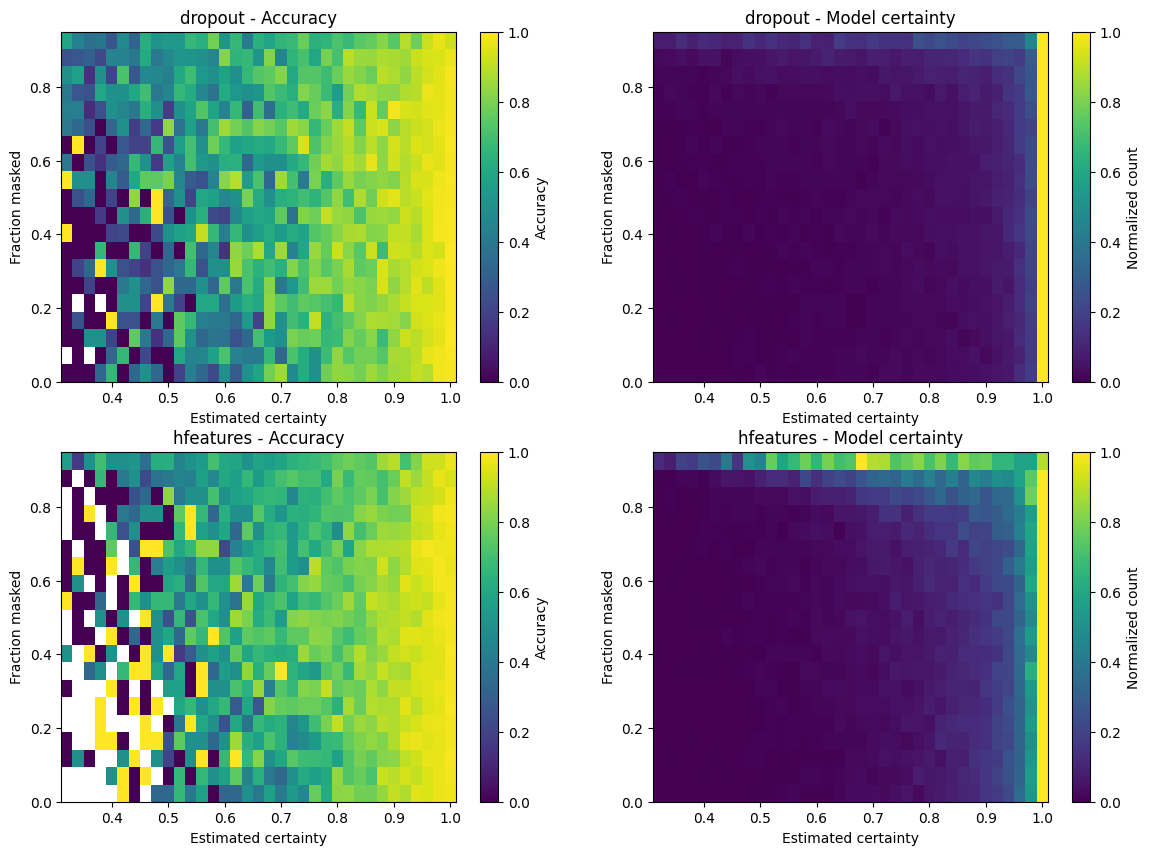

In [33]:
fig, axs = plt.subplots(2,2,figsize=(14,10))
drop_name = '002'
title_names = ['Accuracy','Model certainty']

for i,type in enumerate(estimator_type):

    pred_acc = uncertainty_drops_tunned[type][drop_name]['acc_bin']
    predm = uncertainty_drops_tunned[type][drop_name]['conf_bin']
    
    pcm1 = axs[i,1].imshow(predm, aspect='auto',origin='lower',extent=[hbins[0]+0.01,hbins[-1]+0.01,fraction_levels[0],fraction_levels[-1]])
    axs[i,1].set(xlabel='Estimated certainty',ylabel='Fraction masked',title=f"{type} - {title_names[1]}")

    pcm2 = axs[i,0].imshow(pred_acc, aspect='auto',origin='lower',extent=[hbins[0]+0.01,hbins[-1]+0.01,fraction_levels[0],fraction_levels[-1]])
    axs[i,0].set(xlabel='Estimated certainty',ylabel='Fraction masked',title=f"{type} - {title_names[0]}")
    cbar = fig.colorbar(pcm2,ax=axs[i,0])
    cbar.set_label('Accuracy')
    cbar2 = fig.colorbar(pcm1,ax=axs[i,1])
    cbar2.set_label('Normalized count')
plt.show()

Both estimators certainty seem to match well with actual accuracies computed accross a wide range of masking levels (0-0.95). Note that the accuracies corresponding to low certainty estimates are, in general, noisy due to the lack of data on that range. Let's take a closer look at different intervals of estimated certainties and check how well the actual accuracies follow the estimates.

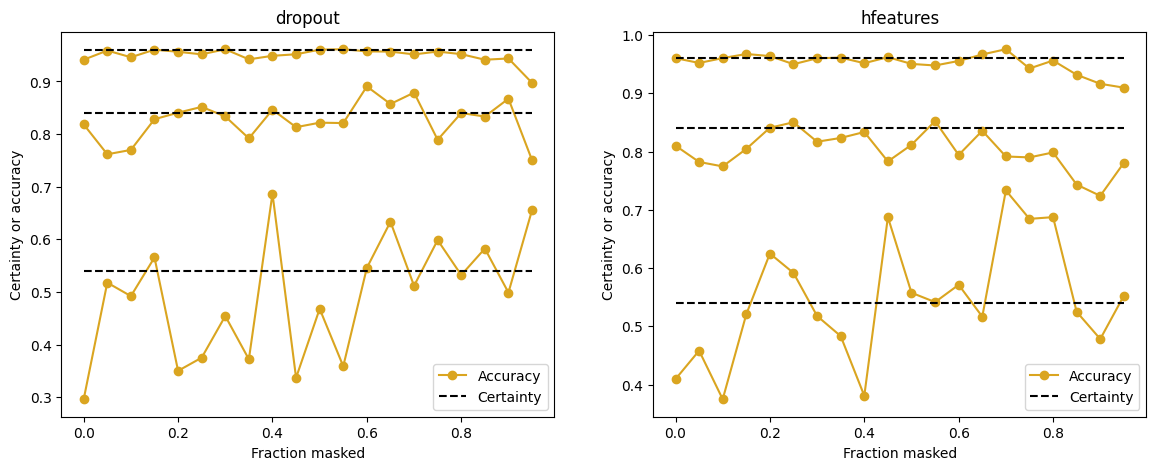

In [34]:
fig, axs = plt.subplots(1,2,figsize=(14,5))

c_ranges = np.stack((np.arange(10,14),np.arange(25,29),np.arange(31,35)),axis=1)

for i,type in enumerate(estimator_type):

    for c in range(3):
        pred_acc = uncertainty_drops_tunned[type][drop_name]['acc_bin']

        axs[i].plot(fraction_levels,np.mean(pred_acc[:,c_ranges[:,c]],axis=1),'o-',color='goldenrod')
        axs[i].plot(fraction_levels,np.tile(np.mean(uncertainty_drops_tunned['model confidence'][c_ranges[:,c]]),20),'--',color='black')
        axs[i].set(xlabel='Fraction masked',ylabel='Certainty or accuracy',title=type)
    axs[i].legend(['Accuracy', 'Certainty'])
plt.show()

I checked 3 intervals of certainty, centered at 0.54, 0.84 and 0.96. As mentioned before, accuracy profiles are noisy for the lowest certainty range. For the highly certain predictions, accuracies closely match certainty but tend to drop at high masking levels, particularly in the case of the h-features based estimator. That trend might be a result of the drop in CNN model accuracy on highly corrupted images. So, I checked how accuracy varies accross masking levels for both estimators.

In [14]:
acc_masking = []
for type in estimator_type:
    inst = uncertainty_drops_tunned[type][drop_name]['validation']['wrong']
    n_total = inst.size(1)
    n_wrong = torch.sum(inst,1)
    acc_masking.append(1-n_wrong/n_total)

In [32]:
def calculate_total_error(uncertainty_drops,corruption_levels):
    
    xp = uncertainty_drops['model confidence']
    y_err = np.zeros((corruption_levels.shape[0],2))
    print(corruption_levels.shape[0])
    for i in range(corruption_levels.shape[0]):
        
        yp = np.array([uncertainty_drops['dropout'][drop_name]['acc_bin'][i,:],
               uncertainty_drops['hfeatures'][drop_name]['acc_bin'][i,:]]).T

        yp = np.where(np.isnan(yp),0,yp)
        #print(yp)

        yc = np.array([uncertainty_drops['dropout'][drop_name]['conf_bin'][i,:],
                    uncertainty_drops['hfeatures'][drop_name]['conf_bin'][i,:]]).T
        y_err[i,:] = np.sum(np.abs(yp-np.tile(xp.reshape(-1,1),(1,2)))*yc,axis=0)
        
    return y_err

In [ ]:
total_binned_error = calculate_total_error(uncertainty_drops_tunned,fraction_levels)

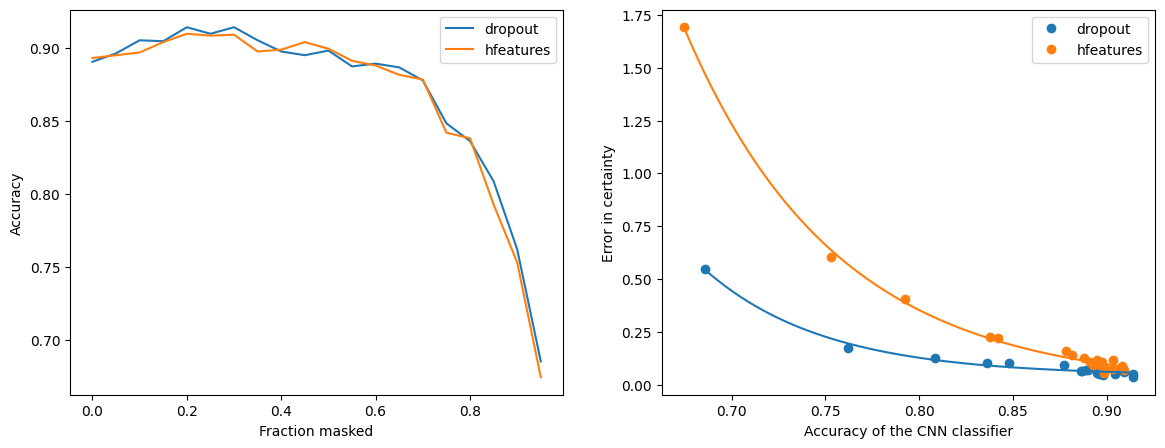

In [87]:
fig, axs = plt.subplots(1,2,figsize=(14,5))
x_names = ['Fraction masked','Certainty']
y_names = 'Accuracy'

for i,type in enumerate(estimator_type):
    axs[0].plot(fraction_levels,acc_masking[i])
    axs[0].set(xlabel='Fraction masked',ylabel='Accuracy')
    axs[0].legend(estimator_type)
    
    pred_acc = uncertainty_drops_tunned[type][drop_name]['acc_bin']
    #axs[1].plot(np.mean(pred_acc[:,c_ranges[:,2]],axis=1),acc_masking[i],'o')
    axs[1].plot(acc_masking[i],total_binned_error[:,i],'o')
    axs[1].set(xlabel='Accuracy of the CNN classifier',ylabel='Error in certainty')
    axs[1].legend(estimator_type)

# Define an exponential decay function
def exp_decay(x, a, b, c):
    return a * np.exp(-b * x) + c

# Get the default color cycle
colors_default = plt.rcParams['axes.prop_cycle'].by_key()['color']

for i in range(2):
    params1, _ = curve_fit(exp_decay, np.array(acc_masking[i]),total_binned_error[:,i],p0=[50,7,0])
    
    xfit = np.arange(torch.min(acc_masking[i]),torch.max(acc_masking[i]),0.001)
    axs[1].plot(xfit,exp_decay(xfit,*params1),color=colors_default[i])
    
plt.show()

As expected, accuracy drops with masking extent. Plotting the accuracy at each masking level vs corresponding certainty level reveals an approximately exponential relationshiop between the two variables.

These observations suggest that certainty estimation is coupled with the CNN performance and probably to the extent to which a sample falls withing the distribution of the training data. In this case, the dropout-based estimator seems to be more robust to input corruption (by masking) keeping a good performance for masking levels up to 90%.

## Test the models with different noise levels
Given the previous observations, I tested estimators' performance with a different kind of corruption, not present in the training dataset, consisting in noise addition to the input images. Here, I picked the CNNs trained with a dropout of 0.02 since the best certainty estimators were obtained from their outputs.

In [ ]:
dropouts = [0.02]
drop_names = ['002']
estimator_type = ['dropout','hfeatures']
noise_levels = np.arange(0,155,10)

uncertainty_drops_noise = get_estimator_accuracy(train_estimators(C=[1,0.02],features_file='uncertainty_all_noise.pth',
                                                                 clf=uncertainty_drops_tunned))

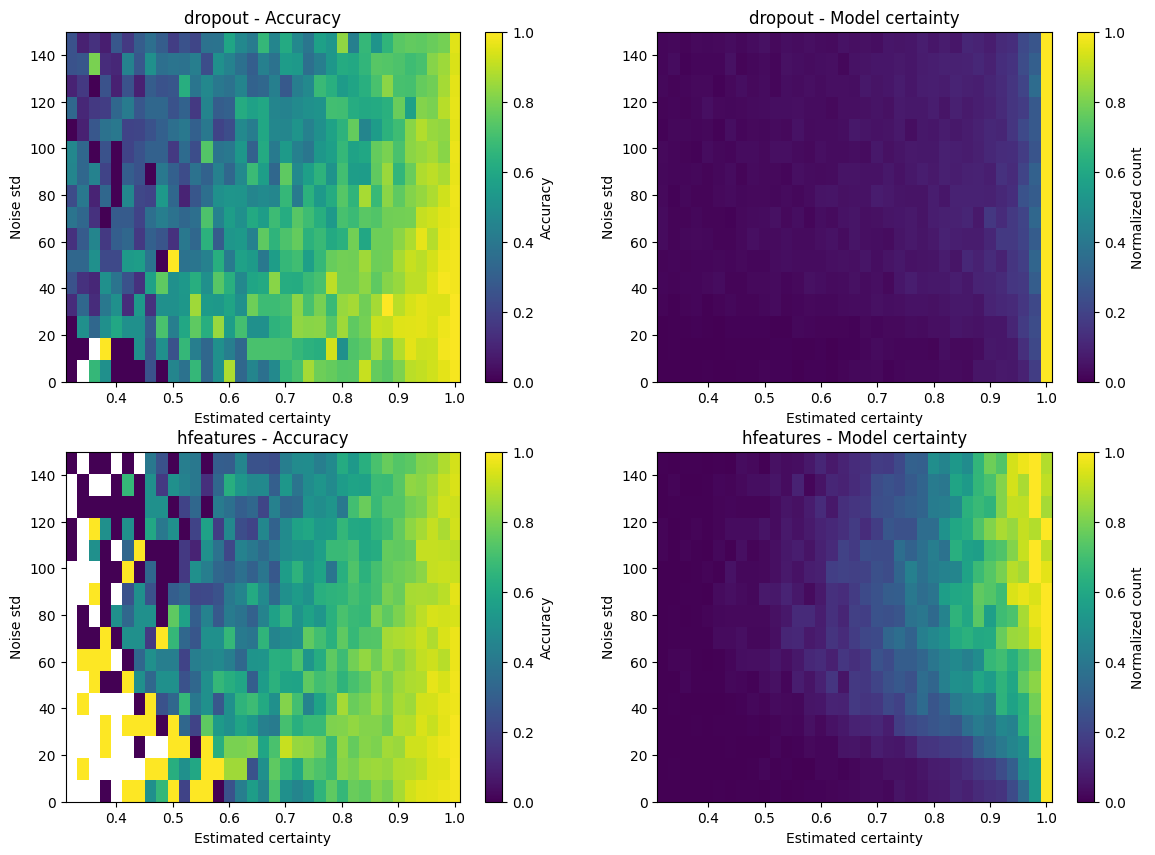

In [35]:
fig, axs = plt.subplots(2,2,figsize=(14,10))
drop_name = '002'
title_names = ['Accuracy','Model certainty']

for i,type in enumerate(estimator_type):

    pred_acc = uncertainty_drops_noise[type][drop_name]['acc_bin']
    predm = uncertainty_drops_noise[type][drop_name]['conf_bin']
    
    pcm1 = axs[i,1].imshow(predm, aspect='auto',origin='lower',extent=[hbins[0]+0.01,hbins[-1]+0.01,noise_levels[0],noise_levels[-1]])
    axs[i,1].set(xlabel='Estimated certainty',ylabel='Noise std',title=f"{type} - {title_names[1]}")

    pcm2 = axs[i,0].imshow(pred_acc, aspect='auto',origin='lower',extent=[hbins[0]+0.01,hbins[-1]+0.01,noise_levels[0],noise_levels[-1]])
    axs[i,0].set(xlabel='Estimated certainty',ylabel='Noise std',title=f"{type} - {title_names[0]}")
    cbar = fig.colorbar(pcm2,ax=axs[i,0])
    cbar.set_label('Accuracy')
    cbar2 = fig.colorbar(pcm1,ax=axs[i,1])
    cbar2.set_label('Normalized count')
plt.show()

In this case, the change in certainty estimation with image corruption is more evident for bothe estimators. There seems to be a decrease in actual accuracies for the high range of certainties in both cases (left plots). Interestingly, the estimators' certainty distributions "react" quite differently to the increase in noise. The hfeatures-based estimator outputs much more lower certainty values for large noise levels, something not so evident in the case of dropout-based certainties.

Let's have a look at selected certainty ranges, as shown before.

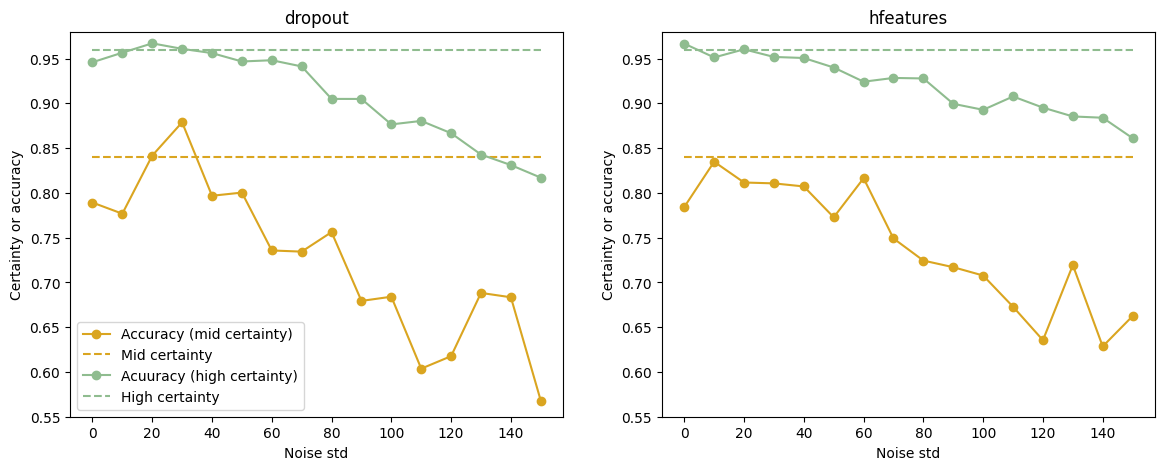

In [37]:
fig, axs = plt.subplots(1,2,figsize=(14,5))

c_ranges = np.stack((np.arange(25,29),np.arange(31,35)),axis=1)
color_names = ['goldenrod','darkseagreen']

for i,type in enumerate(estimator_type):

    for c in range(2):
        pred_acc = uncertainty_drops_noise[type][drop_name]['acc_bin']

        axs[i].plot(noise_levels,np.mean(pred_acc[:,c_ranges[:,c]],axis=1),'o-',color=color_names[c])
        axs[i].plot(noise_levels,np.tile(np.mean(uncertainty_drops_noise['model confidence'][c_ranges[:,c]]),16),'--',color=color_names[c])
        axs[i].set(xlabel='Noise std',ylabel='Certainty or accuracy',title=type,ylim=[0.55,0.98])
    if i==0:
        axs[i].legend(['Accuracy (mid certainty)', 'Mid certainty','Acuuracy (high certainty)','High certainty'])
plt.show()

Here, the over-estimation of certainty is quite evident under high noise level for both models. Let's then check how certainty estimation relates to CNN model accuracy.

In [ ]:
acc_masking_noise = []
for type in estimator_type:
    inst = uncertainty_drops_noise[type][drop_name]['validation']['wrong']
    n_total = inst.size(1)
    n_wrong = torch.sum(inst,1)
    acc_masking_noise.append(1-n_wrong/n_total)
    
total_binned_error_noise = calculate_total_error(uncertainty_drops_noise, noise_levels)

In [35]:
from scipy.optimize import curve_fit

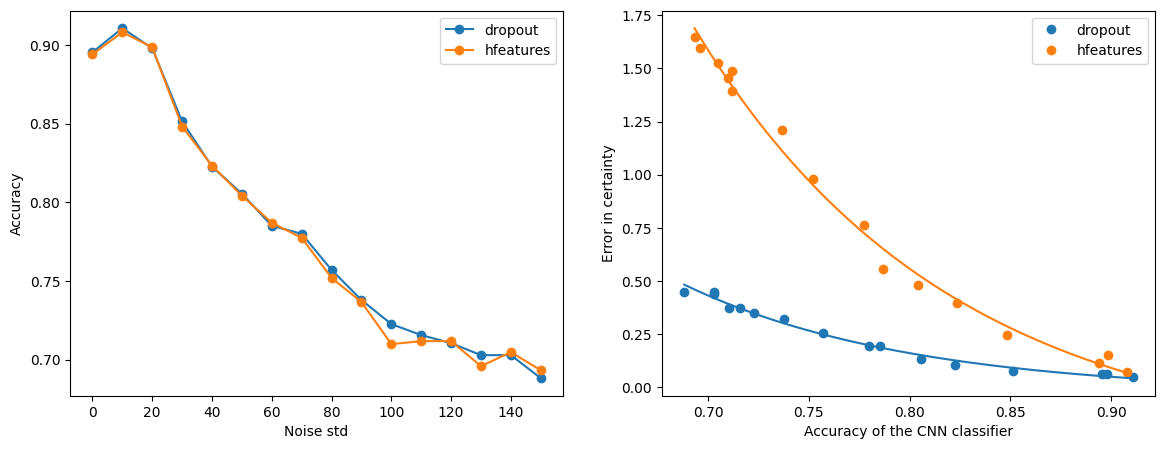

In [89]:
fig, axs = plt.subplots(1,2,figsize=(14,5))
x_names = ['Fraction masked','Certainty']
y_names = 'Accuracy'

for i,type in enumerate(estimator_type):
    axs[0].plot(noise_levels,acc_masking_noise[i],'o-')
    axs[0].set(xlabel='Noise std',ylabel='Accuracy')
    axs[0].legend(estimator_type)
    
    pred_acc = uncertainty_drops_noise[type][drop_name]['acc_bin']
    axs[1].plot(acc_masking_noise[i],total_binned_error_noise[:,i],'o')
    axs[1].set(xlabel='Accuracy of the CNN classifier',ylabel='Error in certainty')
    axs[1].legend(estimator_type)
    
# Define an exponential decay function
def exp_decay(x, a, b, c):
    return a * np.exp(-b * x) + c

# Get the default color cycle
colors_default = plt.rcParams['axes.prop_cycle'].by_key()['color']

params1_noise = 0
for i in range(2):
    params1_noise, _ = curve_fit(exp_decay, np.array(acc_masking_noise[i]),total_binned_error_noise[:,i],p0=[50,7,0])

    xfit = np.arange(torch.min(acc_masking_noise[i]),torch.max(acc_masking_noise[i]),0.001)
    axs[1].plot(xfit,exp_decay(xfit,*params1_noise),color=colors_default[i])
    
plt.show()

The results show qualitatively the same relationships I observed before with masking-based corruption, now with a more resolved exponential increase in the total error in certainty with decreasing CNN accuracy. This corroborates the idea the out of distribution and high image corruption, which decreasy CNN accuracy in image classification, affect the estimation of certainty of CNN predictions. In real life applications, this factors should be taken into consideration when implementing certainty estimation. In order to get reliable certainty estimates, efforts should be taken to keep input images within the range of training data set.

## Conclusions

In this notebook I implemented a simple and effective method to estimate the certainty of a CNN classifier predictions. I take advantage of the known ability of logistic regression classifiers to output probability of a sample belonging to a certain class. In this context, the derived estimators output the probability of a given CNN prediction being actually true. I show that this approach allows direct estimation of prediction certainty without requiring further calibrations.
The certainty estimators' performance is quite decent for a wide range of image corruption extent either by masking or noise addition, showcasing its usefullness in real-life applications.

## Limitations
- The results show that extreme image corruption dereases both CNN accuracy and the performance of certainty estimation. Thus, in order to get reliable certainty estimates in real life applications, efforts should be taken to keep input images within the range of training data set.
  
- The droupout-based certainty estimation at 2% dropout extent provided the best results. However, in real-life the applicability of such approach might be limitted by computational resources, since it requires many (here 50) forward passes on the CNN to get the estimate. Alternatively, using plain deterministic CNN output (dropout of zero) provided a decent performance, even slighlt better then the hfeatures-based approach.